In [ ]:
!pip install gensim scikit-learn

import numpy as np
import gensim
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

# Word vector arithmetics and biases

In [ ]:
# available word embedding models on Gensim
print(list(gensim.downloader.info()['models'].keys()))

w2v = gensim.downloader.load('word2vec-google-news-300')
print(dir(w2v))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 1662.8/1662.8MB downloaded
['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_log_evaluate_word_analogies', '_save_specials', '_smart_save', '_upconvert_old_d2vkv', '_upconvert_ol

In [ ]:
class ArithmeticPlotter:
  def __init__(self, words, extra_words, embeddings):
    self.words = words
    self.embeddings = embeddings
    self.vectors = {}
    self.extra_vectors = []

    for word in words:
      self.vectors[word] = embeddings[word]
    for word in extra_words:
      self.extra_vectors.append(embeddings[word])

    self.arrows = []
    self.arrows_to_nearest = []

  def add_arrow(self, differences: list[tuple[str, str]], word_origin: str, **kwargs):
    self.arrows.append((differences, word_origin, kwargs))

  def add_arrow_to_nearest(self, differences: list[tuple[str, str]], word_origin: str, num_of_nearest: int, show_taken_arrow = False, **kwargs):
    self.arrows_to_nearest.append((differences, word_origin, num_of_nearest, show_taken_arrow, kwargs))

  def plot(self, n_components=2):
    if n_components==3:
      ax = plt.figure(figsize=(10,14)).add_subplot(projection='3d')
    else:
      ax = plt.figure(figsize=(10,7)).add_subplot()

    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit([*self.vectors.values()] + self.extra_vectors)
    pca_vectors = {}
    for word, vector in self.vectors.items():
      pca_vectors[word] = pca.transform([vector])[0]

    for word, vector in pca_vectors.items():
      ax.scatter(*vector, label=word)
      ax.text(*vector, word)

    for differences, word_origin, kwargs in self.arrows:
      diff = np.mean([
          pca.transform([self.embeddings[word_to]])[0] - pca.transform([self.embeddings[word_from]])[0]
          for (word_from, word_to) in differences
      ], axis=0)
      ax.arrow(*pca.transform([self.embeddings[word_origin]])[0], *diff, **kwargs)

    for differences, word_origin, num_of_nearest, show_taken_arrow, kwargs in self.arrows_to_nearest:
      diff = np.mean([
          self.embeddings[word_to] - self.embeddings[word_from]
          for (word_from, word_to) in differences
      ], axis=0)
      ax.arrow(*pca.transform([self.embeddings[word_origin]])[0], *pca.transform([diff])[0], **kwargs)

      if show_taken_arrow:
        orig_mean = np.mean([
            self.embeddings[word_from]
            for (word_from, word_to) in differences
        ], axis=0)
        ax.arrow(*pca.transform([orig_mean])[0], *pca.transform([diff])[0], **kwargs)

      nearest_words = self.embeddings.similar_by_vector(self.embeddings[word_origin] + diff, num_of_nearest)
      for i, (word, distance) in enumerate(nearest_words):
        ax.scatter(*pca.transform([self.embeddings[word]])[0], label=word, marker='x', color='gray')
        ax.text(*pca.transform([self.embeddings[word]])[0], word)

    plt.title(f"{n_components} principal components of selected w2v embeddings")
    plt.show()



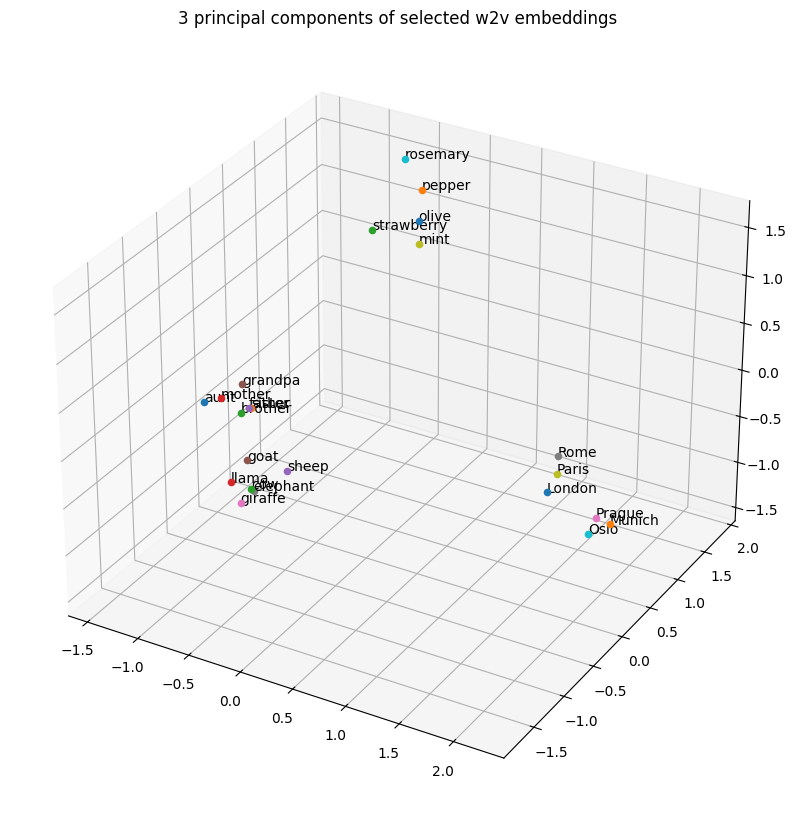

In [ ]:
p = ArithmeticPlotter(
    [
        'aunt', 'sister', 'brother', 'mother', 'father', 'grandpa',
        'Prague', 'Rome', 'Paris', 'Oslo', 'London', 'Munich',
        'cow', 'llama', 'sheep', 'goat', 'giraffe', 'elephant',
        'mint', 'rosemary', 'olive', 'pepper', 'strawberry'
    ], [], w2v)
p.plot(n_components=3)

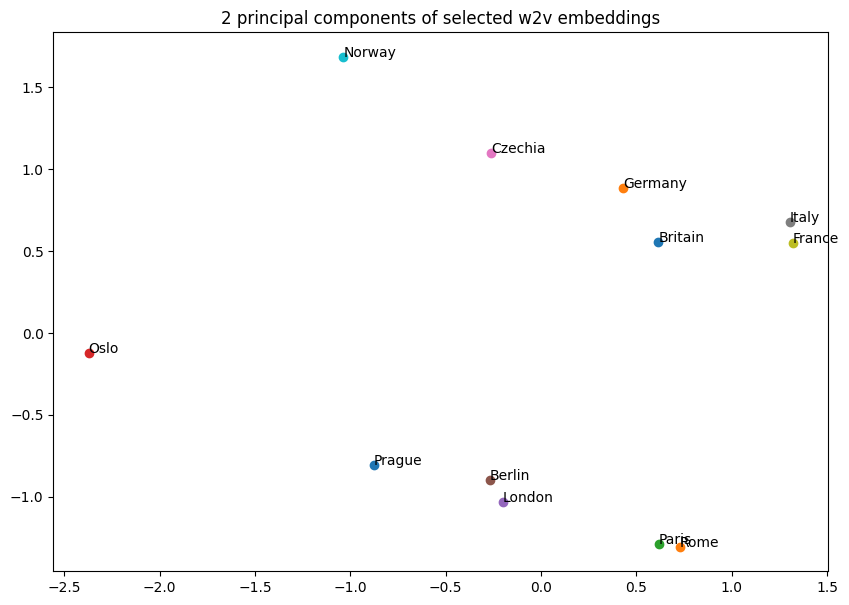

In [ ]:
p = ArithmeticPlotter(
    [
        'Prague', 'Rome', 'Paris', 'Oslo', 'London', 'Berlin',
        'Czechia', 'Italy', 'France', 'Norway', 'Britain', 'Germany',
    ], [], w2v)
p.plot(n_components=2)

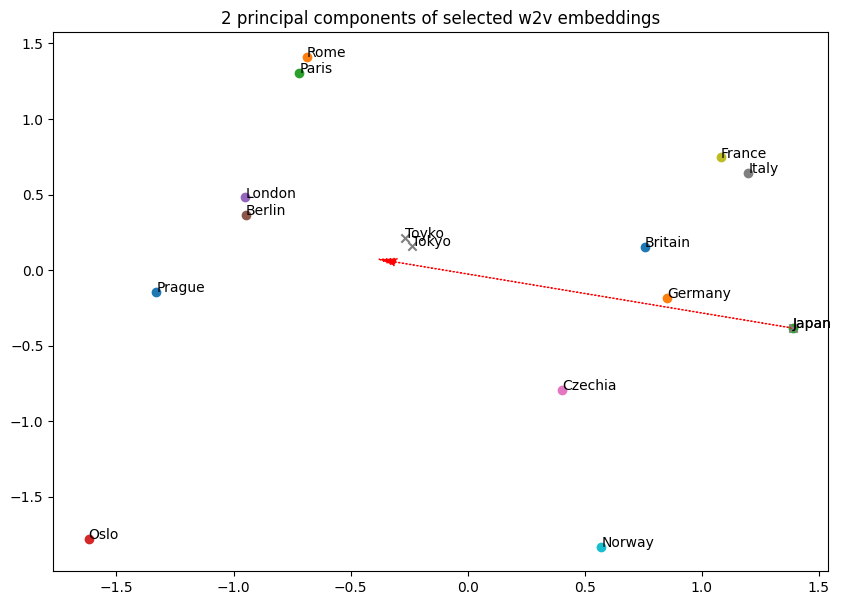

In [ ]:
p = ArithmeticPlotter(
    [
        'Prague', 'Rome', 'Paris', 'Oslo', 'London', 'Berlin',
        'Czechia', 'Italy', 'France', 'Norway', 'Britain', 'Germany', 'Japan'
    ], [], w2v)
p.add_arrow_to_nearest(
    [
      ('Czechia', 'Prague'), ('Italy', 'Rome'), ('France', 'Paris'),
      ('Norway', 'Oslo'), ('Britain', 'London'), ('Germany', 'Berlin')
    ], 'Japan', num_of_nearest=3,
    color='r', linestyle='dotted', head_width=0.05
)
p.plot(n_components=2)

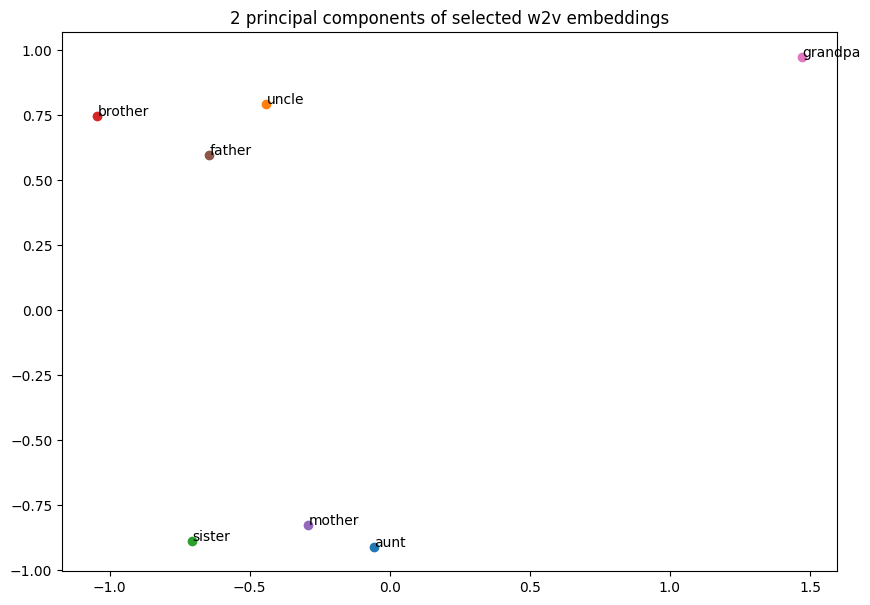

In [ ]:
p = ArithmeticPlotter(['aunt', 'uncle', 'sister', 'brother', 'mother', 'father', 'grandpa'], ['grandma'], w2v)
p.plot()

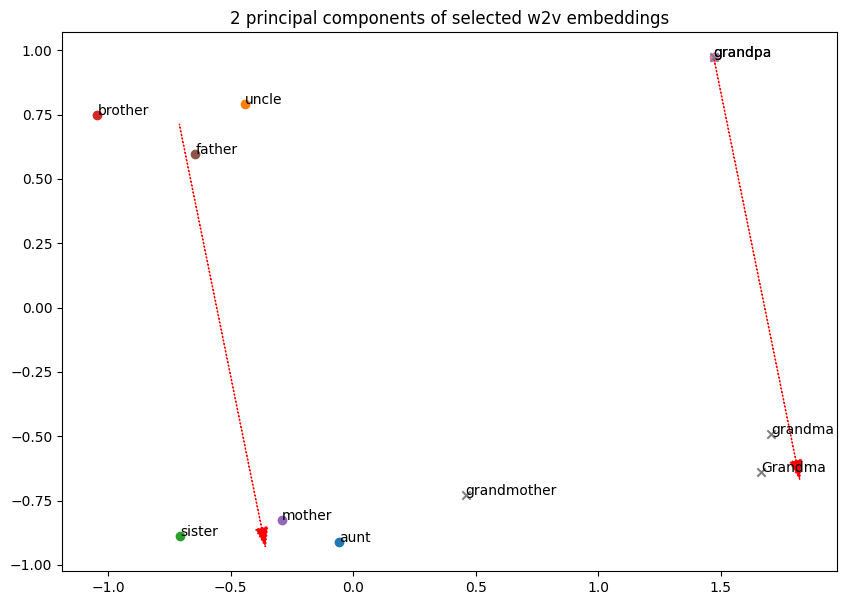

In [ ]:
p = ArithmeticPlotter(['aunt', 'uncle', 'sister', 'brother', 'mother', 'father', 'grandpa'], ['grandma'], w2v)
p.add_arrow_to_nearest(
    [('brother', 'sister'), ('uncle', 'aunt'), ('father', 'mother')],
    'grandpa',
    num_of_nearest=4,
    show_taken_arrow=True,
    color='r', linestyle='dotted', head_width=0.05)

p.plot()

In [ ]:
# @title
class BiasPlotter:
  def __init__(self, target_a: str, target_b: str, title, figsize, embeddings):
    self.target_a = target_a
    self.target_b = target_b
    self.embeddings = embeddings
    self.title = title
    self.figsize = figsize

  def plot_biases(self, words: list[str], similarity):
    a = self.embeddings[self.target_a]
    b = self.embeddings[self.target_b]

    similarities_a = []
    similarities_b = []
    for word in words:
      word_vec = self.embeddings[word]
      similarities_a.append(similarity(a, word_vec))
      similarities_b.append(similarity(b, word_vec))

    similarities_a = np.array(similarities_a)
    similarities_b = np.array(similarities_b)
    mean_sim = (similarities_b - similarities_a) / 2

    together = list(zip(words, similarities_a, similarities_b, mean_sim))
    together = sorted(together, key=lambda x: x[3])

    words, similarities_a, similarities_b, mean_sim = zip(*together)
    similarities_a = np.array(similarities_a)
    similarities_b = np.array(similarities_b)
    mean_sim = np.array(mean_sim)

    ax = plt.figure(figsize=self.figsize).add_subplot()

    ax.barh(words, -similarities_a, label=self.target_a, color='#3399cc', zorder=3)
    ax.barh(words, similarities_b, label=self.target_b, color='#cc3333', zorder=3)
    # plot the mean (similarities_a + similarities_b) / 2 for each word as a black vertical line marker in the given bar
    ax.scatter(mean_sim, words, color='black', marker='|', s=500, zorder=3)


    max_sim = max(max(similarities_a), max(similarities_b))
    # set x axis limits to -1 1
    plt.xlim(-max_sim - 0.05, max_sim + 0.05)

    # define x tic at -0.5 and 0.5 as the target words
    plt.xticks([-max_sim, max_sim, 0], [self.target_a, self.target_b, 'neutral'])

    # put xtics to the top of the plot
    plt.gca().xaxis.tick_top()

    # put xtics to the right of the plot
    ax.grid(color='gray', linestyle='--', zorder=0)
    plt.title(self.title)
    plt.show()

In [ ]:
def cosine_similarity(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

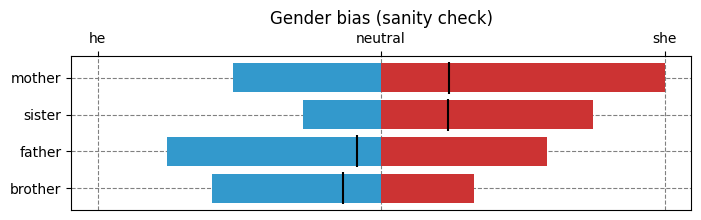

In [ ]:
bp = BiasPlotter('he', 'she', "Gender bias (sanity check)", (8, 2), w2v)
bp.plot_biases([
    'brother', 'sister',
    'father', 'mother',
], cosine_similarity)

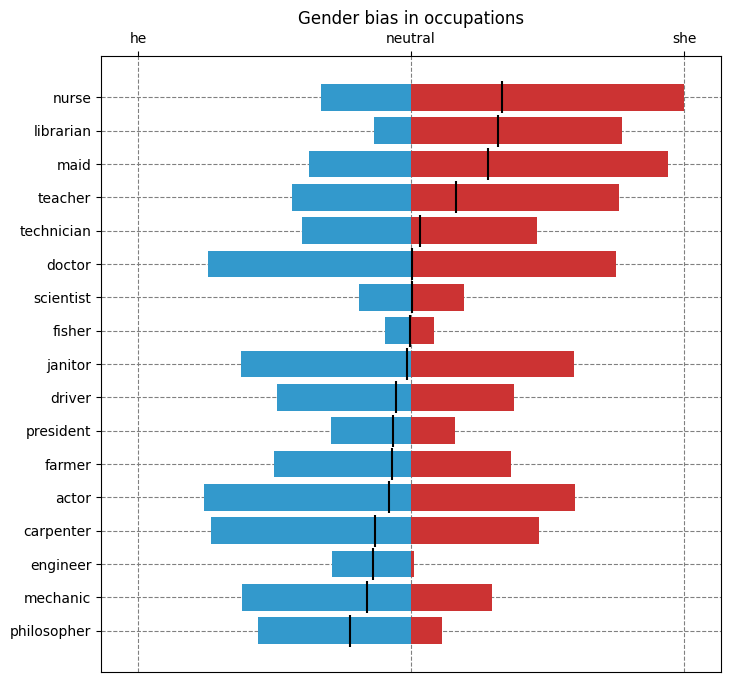

In [ ]:
bp = BiasPlotter('he', 'she', "Gender bias in occupations", (8, 8), w2v)
bp.plot_biases([
    'doctor', 'nurse',
    'engineer', 'philosopher',
    'maid', 'librarian',
    'actor', 'janitor',
    'teacher', 'driver',
    'president', 'scientist',
    'farmer', 'fisher',
    'mechanic', 'technician', 'carpenter'
], cosine_similarity)

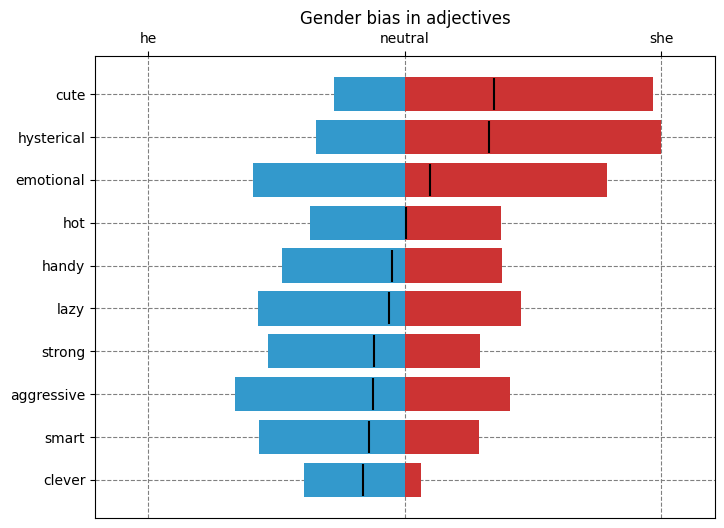

In [ ]:
bp = BiasPlotter('he', 'she', "Gender bias in adjectives", (8, 6), w2v)
bp.plot_biases([
    'cute', 'hot',
    'smart', 'strong', 'handy',
    'hysterical', 'emotional',
    'aggressive','lazy',
    'clever',
], cosine_similarity)